In [1]:
import numpy as np
import open3d as o3d
import copy
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## File IO

In [2]:
stl_mesh = o3d.io.read_triangle_mesh("stl_mesh.stl")
obj_mesh = o3d.io.read_triangle_mesh("obj_mesh.obj")

## Visualization

In [3]:
mesh = obj_mesh
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])

In [4]:
# o3d.visualization.draw_geometries([mesh, mesh_frame])

In [5]:
# scaled_mesh = copy.deepcopy(mesh)
# scaled_mesh.scale(1 / np.max(scaled_mesh.get_max_bound() - scaled_mesh.get_min_bound()), center=scaled_mesh.get_center())
# o3d.visualization.draw_geometries([scaled_mesh, mesh_frame])

## Normalization

### Center the Mesh

In [6]:
print(mesh.get_center())
centered_vertices = np.array(mesh.vertices) - mesh.get_center()
mesh.vertices = o3d.utility.Vector3dVector(centered_vertices)
print(mesh.get_center())

[ 0.72569102 -0.68593362 10.31785828]
[-7.68295749e-13 -6.04510797e-13 -5.92657940e-12]


### Scale the Points

In [7]:
print(mesh.get_min_bound(), mesh.get_max_bound())
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
print(mesh.get_min_bound(), mesh.get_max_bound())

[-33.08519572  -4.25436637 -42.67735916] [31.63381368  2.27343359 75.54260773]
[-0.27986132 -0.03598687 -0.36099959] [0.26758436 0.01923054 0.63900041]


In [8]:
# o3d.visualization.draw_geometries([mesh, mesh_frame])

## Voxelization and Holes

In [45]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.02)
# o3d.visualization.draw_geometries([voxel_grid])

In [46]:
voxels = np.array(list(map(lambda x: x.grid_index, voxel_grid.get_voxels())))

In [47]:
def points_in_cylinder(pt1, pt2, r, q):
    vec = pt2 - pt1
    const = r * np.linalg.norm(vec)
    cond1 = np.dot(q - pt1, vec) >= 0
    cond2 = np.dot(q - pt2, vec) <= 0
    cond3 = np.linalg.norm(np.cross(q - pt1, vec), axis=1) <= const
    
    cond4 = np.logical_and(cond1, cond2)
    cond5 = np.logical_and(cond3, cond4)
    return cond5

In [48]:
points = np.asarray(mesh.vertices)

maxx = np.max(points, axis=0)
minn = np.min(points, axis=0)

pt1 = voxel_grid.get_center()
pt2 = voxel_grid.get_center()

idx = 2
pt1[idx] =  minn[idx]
pt2[idx] =  maxx[idx]

In [49]:
idx = points_in_cylinder(pt1, pt2, 0.05, points)
to_be_removed = points[idx]

In [50]:
voxels_to_be_removed = np.unique(list(map(lambda x: voxel_grid.get_voxel(x), to_be_removed)), axis = 0)

In [51]:
# voxels_to_be_removed = list(map(lambda x: o3d.geometry.Voxel(x), voxels_to_be_removed))

In [52]:
N = voxels.max()
voxels_occ_grid = np.zeros((N,N,N))

In [53]:
for v in voxels:
    voxels_occ_grid[v[0]-1, v[1]-1, v[2]-1] = 1

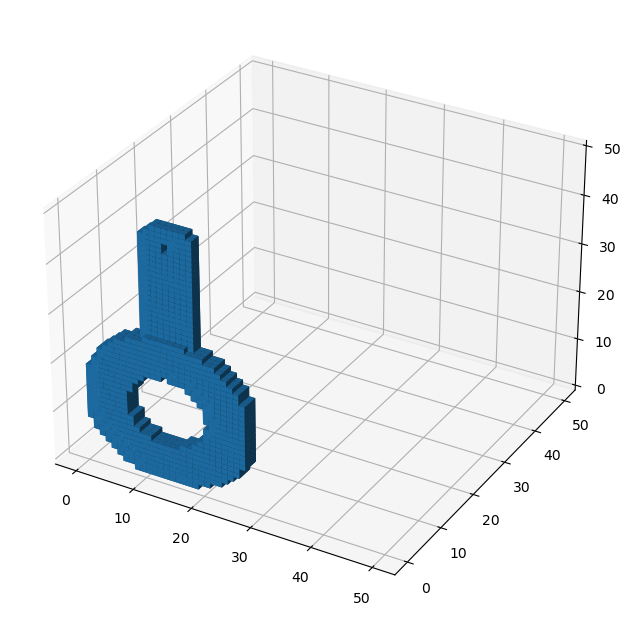

In [54]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
ax.voxels(voxels_occ_grid)
plt.show()

In [55]:
for v in voxels_to_be_removed:
    voxels_occ_grid[v[0]-1, v[1]-1, v[2]-1] = 0

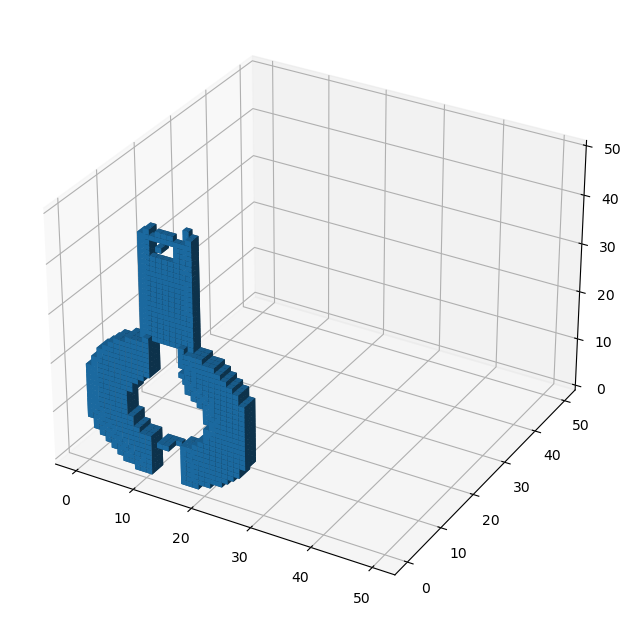

In [56]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
ax.voxels(voxels_occ_grid)
plt.show()